<h1>Datetime recognizer</h1>
Train a model to recognize any datetimes in a given text string. 

Start with simple iso8601s and then progress to locales, timezones, countries & conventions.


Starting from the Keras autoencoder example.

In [1]:
import os

os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64'
os.environ['CUDA_HOME'] = '/usr/local/cuda'

In [2]:
# -*- coding: utf-8 -*-
'''An implementation of sequence to sequence learning to decode localized datetimes from strings
Input: "Monday 31 December 2007 07:07:07.0000000 +02:00 CET/Europe"
or
       "Monday, 24 October 1977 at 09:10:55 Greenwich Mean Time"
Output: "2007-12-31T07:07:07.00000+02:00"
Padding is handled by using a repeated sentinel character (space)


Input may optionally be inverted, shown to increase performance in many tasks in:
"Learning to Execute"
http://arxiv.org/abs/1410.4615
and
"Sequence to Sequence Learning with Neural Networks"
http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf
Theoretically it introduces shorter term dependencies between source and target.

'''
from keras.models import Sequential
from keras.engine.training import slice_X
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent, Dropout, Flatten, Embedding ,Merge
from keras.layers.convolutional import Convolution1D, Cropping1D, UpSampling1D, Convolution2D
from keras.layers.pooling import MaxPooling1D
from keras.layers.local import LocallyConnected1D
from keras.optimizers import Adam, SGD, RMSprop, Nadam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.layers.wrappers import Bidirectional
from keras.layers.core import Reshape
#from keras.callbacks import ReduceLROnPlateau
import numpy as np
from six.moves import range
import pytz
from datetime import datetime, timezone
import itertools
import random
from babel import Locale, localedata, UnknownLocaleError
from babel.dates import format_datetime
from tqdm import tqdm
import sys
import string
import math

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
import math

In [4]:
%matplotlib inline

In [5]:
class CharacterTable(object):
    '''
    Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    '''
    def __init__(self, country_codes, maxlen):
        self.chars = set(string.ascii_letters + 
                         string.punctuation + 
                         string.digits
                        )

        ts_from = int(datetime(1980, 1, 1, tzinfo=timezone.utc).timestamp())
        ts_to   = int(datetime(1981, 1, 1, tzinfo=timezone.utc).timestamp())
        tstamps = [t for t in range(ts_from, ts_to, 60*1000)]
        retries = 0
        
        #Hoover up all the non-ascii characters that might be needed
        for country_code in tqdm(country_codes):
            try:                            
                if pytz.country_timezones.get(country_code):
                    for ctzone in pytz.country_timezones(country_code):
                        tzone = pytz.timezone(ctzone)
                        country_locale = Locale.parse('und_' + country_code)
                        for fmt  in ['short','medium','long','full']:
                            ydts = [datetime.utcfromtimestamp(t).replace(tzinfo=tzone) for t in tstamps]
                            if random.choice([True, False]):
                                X = [format_datetime(dt, format=fmt, locale=country_locale) for dt in ydts]
                            else:
                                sep = random.choice([' ','T'])
                                X = [dt.isoformat(sep) for dt in ydts]

                            # So that's a years worth of datetimes for all the countrys & locales & timezones 
                            for ln in X:
                                # Going with case sensitive because some dt formats have an "i"
                                self.chars = self.chars.union( set(iter(ln)))
                                
            except UnknownLocaleError:
                print('UnknownLocaleError: %s'%'und_' + country_code, file=sys.stderr)
                retries += 1
                if retries >=21:
                    raise # Somethings gone wrong!

        self.chars = sorted(self.chars)

        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
        self.maxlen = maxlen

    def encode(self, sentence, maxlen=None):
        maxlen = maxlen if maxlen else self.maxlen
        chunk_size = len(self.chars)
        X = np.zeros((maxlen, chunk_size))
        for idx, c in enumerate(sentence[:maxlen]):
            X[idx, self.char_indices[c]] = 1
        return X

    def decode(self, X, maxlen=None):
        maxlen = maxlen if maxlen else self.maxlen
        ret = []
        chunk_size = len(self.chars)
        for idx in range(maxlen):
            retidx = X[idx,:].argmax(axis=-1)
            ret.append(self.indices_char[retidx])
        return ''.join(ret)


In [6]:
TESTSTRING = 'Monday 21st 1998-01-11 +GMT'
ctable = CharacterTable(['GB',], len("Monday 31 December 2007 07:07:07.0000000 +02:00 CET/Europe"))
xxx = ctable.encode(TESTSTRING)
yyy = ctable.decode(xxx)
print('Encoded.shape: %s' % str(xxx.shape))
print('Decoded: %s' % yyy)
assert(yyy.strip() == TESTSTRING)


100%|██████████| 1/1 [00:00<00:00,  6.10it/s]

Encoded.shape: (58, 95)
Decoded: Monday 21st 1998-01-11 +GMT                               


In [7]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [8]:
def DateTimeDataGenerator(sample_size):   
    while True:        
        # 0xFFFFFFFF 32 bit unsigned max 2106
        # 0x7FFFFFFF 32 bit   signed max 2038
        tstamps = [random.randrange(0xFFFFFFFF) for _ in range(sample_size)]

        yield tstamps


In [9]:
def DateTimeFormattedGenerator(country_codes, sample_size, maxlen_x, maxlen_y):
    dtdg = DateTimeDataGenerator(sample_size)
    all_locales = localedata.locale_identifiers()
    limit          = 8
    locale_choices = []
    retries        = 0
    
    # Gather country and timezone options
    for country_code in country_codes:
        try:                            
            if pytz.country_timezones.get(country_code):
                for ctzone in pytz.country_timezones(country_code):
                    tzone = pytz.timezone(ctzone)
                    country_locale = Locale.parse('und_' + country_code)
                    for fmt  in ['short','medium','long','full']:
                        locale_choices.append({'country_code': country_code,
                                               'timezone'    : tzone,
                                               'format'      : fmt,
                                               'locale'      : country_locale
                                              })
        except UnknownLocaleError:
            print('UnknownLocaleError: %s'%'und_' + country_code, file=sys.stderr)
            retries += 1
            if retries >= 21:
                raise
    
    locale_choices = (locale_choices * math.ceil(sample_size/len(locale_choices)))[:sample_size]
    random.shuffle(locale_choices)
    
    while True:        
        # 0xFFFFFFFF 32 bit unsigned max 2106
        # 0x7FFFFFFF 32 bit   signed max 2038
        tstamps = next(dtdg)
        
        ydts  = [ datetime.utcfromtimestamp(t).replace(tzinfo=locale_choices[idx]['timezone']).isoformat('T') 
                  for idx, t in enumerate(tstamps)]        
        X = [format_datetime(datetime.utcfromtimestamp(t).replace(
                     tzinfo=locale_choices[idx]['timezone']), 
                     format=locale_choices[idx]['format'], 
                     locale=locale_choices[idx]['locale']
                     ) 
             for idx, t in enumerate(tstamps)]

        # pad or chop to length
        X    = [(pp + (' '*maxlen_x))[:maxlen_x] for pp in X]
        ydts = [(pp + (' '*maxlen_y))[:maxlen_y] for pp in ydts]
            
        yield (X, ydts)

In [10]:
MAXLEN_X = 72 # longer than anything expected like 'Monday 31 December 2000 07:07:07.0000000 +02:00 CET/Europe'
MAXLEN_Y = len(datetime.now().isoformat(' '))

def DateTimeVectorGenerator(dt_generator, ctable, invert):    
    """
    Returns: x_batch [batch_size, n_timesteps, vocab_size] 
             y_batch [batch_size, n_categories]
    """
    X_next, y_next = next(dt_generator)
    while True:
        # X_next are all the same MAXLEN_X length. Same for y_next
        X = np.zeros((len(X_next), MAXLEN_X, len(ctable.chars)), dtype=np.bool)
        y = np.zeros((len(y_next), MAXLEN_Y, len(ctable.chars)), dtype=np.bool)
        
        for idx, sentence in enumerate(X_next):
            X[idx] = np.flipud(ctable.encode(sentence, MAXLEN_X)) if invert else ctable.encode(sentence, MAXLEN_X)
            
        for idx, sentence in enumerate(y_next):
            y[idx] = ctable.encode(sentence, MAXLEN_Y)
    
        yield [X, X, X], y

In [11]:
def visualize_history(learning_hist, data_filename=None):    
    plt.figure(figsize=(12, 6))
    discard = int(math.ceil(len(learning_hist)/100))*20
    # skip the first few, they destroy plot scale
    plt.plot([i for i in learning_hist[-1].history['loss'][discard:]], label='loss')
    plt.plot([i for i in learning_hist[-1].history['val_loss'][discard:]], label='val_loss')

    plt.ylabel('error')
    plt.xlabel('iteration')
    plt.legend()
    #plt.ylim([0, 0.005])
    plt.title('training error')
    if (data_filename is not None):
        plt.savefig(data_filename)
        plt.close()
    else:
        plt.show()

In [12]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.003 #0.0016875 #0.000533935546875 #0.003
    drop = 0.80 #0.75
    epochs_drop = 33.0        
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))    
    
    if not epoch % epochs_drop:
        print('Learning rate adjusted: {}'.format(lrate), file=sys.stderr)
    
    return lrate

In [13]:
# Parameters for the model and dataset
TRAINING_SIZE   = 2345 #tuned to avoid ResourceExhaustedError: OOM when allocating tensor with shape
VALIDATION_SIZE = 234
INVERT = True
# Try replacing GRU, LSTM or SimpleRNN
RNN = recurrent.LSTM
BATCH_SIZE = 128
LAYERS = 4

# pytz.country_names.keys()
COUNTRY_CODES = ['GB', 'US', 'IE', 'AU', ] #'DE','FR','ES','IT','CA', 'NO','SE','DK','FI','EE','CZ','PL'] 
EPOCHS=106
HIDDEN_SIZE = math.ceil(MAXLEN_X * 1.0) # GRU #9 - SimpleRNN to 80%acc




In [14]:
ctable = CharacterTable(COUNTRY_CODES, MAXLEN_X)

100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


In [15]:
#gen_dt = DateTimeIsoGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y)
gen_dt = DateTimeFormattedGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y)

gen_vec_train      = DateTimeVectorGenerator(gen_dt, ctable, INVERT)
gen_vec_validation = DateTimeVectorGenerator(gen_dt, ctable, INVERT)

X_train, y_train = next(gen_vec_train)
print('X_train[0].shape: %s'%str(X_train[0].shape))
print('y_train.shape: %s'%str(y_train.shape))

X_train[0].shape: (2345, 72, 95)
y_train.shape: (2345, 26, 95)


In [16]:
#gen_dt_test = DateTimeIsoGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y)
gen_dt_test = DateTimeFormattedGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y)

gen_vec_test = DateTimeVectorGenerator(gen_dt_test, ctable, INVERT)

X_test, y_test = next(gen_vec_test)
print('X_test[0].shape:%s \ny_test.shape: %s' % (str(X_test[0].shape), str(y_test.shape)))

X_test[0].shape:(2345, 72, 95) 
y_test.shape: (2345, 26, 95)


In [17]:
stopper = EarlyStopping(patience=25, 
                        verbose=1, 
                        mode='auto')

In [18]:
checkpointer = ModelCheckpoint('../models/checkpoint.{epoch:02d}-{val_loss:.2f}.hdf5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto')

In [19]:
learning_hist = []

In [21]:
# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate, ]

In [30]:
print('Build model...')

filter_lengths = [2,3,4] # "dd" or "mm-" or "/mm" or "GMT" or "yyyy"  
conv_filters = []

for fl in filter_lengths:
    conv_filters.append(Sequential())
    conv_filters[-1].add(Convolution1D(nb_filter=len(ctable.chars),
                        filter_length=fl,
                        activation='relu',
                        input_shape=(MAXLEN_X, len(ctable.chars)),
                        subsample_length=1,
                       ))
    conv_filters[-1].add(MaxPooling1D(pool_length=4)) # was 68 


model = Sequential()
model.add(Merge(conv_filters, mode='concat'))
model.add(Dropout(0.3))
#model.add(Reshape((3,len(ctable.chars))))
#model.add(MaxPooling1D(pool_length=MAXLEN_Y))
model.add(recurrent.GRU(HIDDEN_SIZE, return_sequences=False))
#model.add(Flatten())
model.add(RepeatVector(MAXLEN_Y))
model.add(recurrent.GRU(HIDDEN_SIZE, 
                          activation='relu',
                          return_sequences=True,
                       ))
model.add(Dropout(0.3))
# For each of step of the output sequence, decide which character should be chosen
model.add(TimeDistributed(Dense(len(ctable.chars), 
                                activation='softmax')
                         ))
opt = Nadam(lr=0) # Using LR scheduler

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Build model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_13 (Convolution1D) (None, 71, 95)        18145                                        
____________________________________________________________________________________________________
maxpooling1d_13 (MaxPooling1D)   (None, 17, 95)        0                                            
____________________________________________________________________________________________________
convolution1d_14 (Convolution1D) (None, 70, 95)        27170                                        
____________________________________________________________________________________________________
maxpooling1d_14 (MaxPooling1D)   (None, 17, 95)        0                                            
____________________________________________________________________________

Learning rate adjusted: 0.003


Epoch 1/106
77385/77385 [==============================] - 36s - loss: 2.9013 - acc: 0.1687 - val_loss: 2.3217 - val_acc: 0.2038
Epoch 2/106
77385/77385 [==============================] - 32s - loss: 2.4360 - acc: 0.2132 - val_loss: 2.1815 - val_acc: 0.2406
Epoch 3/106
77385/77385 [==============================] - 32s - loss: 2.1362 - acc: 0.2964 - val_loss: 1.5066 - val_acc: 0.4569
Epoch 4/106
77385/77385 [==============================] - 32s - loss: 1.5356 - acc: 0.4332 - val_loss: 2.1428 - val_acc: 0.3473
Epoch 5/106
77385/77385 [==============================] - 32s - loss: 1.9475 - acc: 0.3598 - val_loss: 1.3944 - val_acc: 0.4660
Epoch 6/106
77385/77385 [==============================] - 32s - loss: 1.4061 - acc: 0.4655 - val_loss: 1.2038 - val_acc: 0.5261
Epoch 7/106
77385/77385 [==============================] - 32s - loss: 1.2404 - acc: 0.5148 - val_loss: 1.1615 - val_acc: 0.5380
Epoch 8/106
77385/77385 [==============================] - 32s - loss: 1.2101 - acc: 0.5189 - val

Learning rate adjusted: 0.0024000000000000002


77385/77385 [==============================] - 32s - loss: 1.3708 - acc: 0.5093 - val_loss: 1.0290 - val_acc: 0.6103
Epoch 35/106
77385/77385 [==============================] - 32s - loss: 1.0373 - acc: 0.5888 - val_loss: 0.9548 - val_acc: 0.6244
Epoch 36/106
77385/77385 [==============================] - 32s - loss: 0.9720 - acc: 0.6125 - val_loss: 0.9127 - val_acc: 0.6450
Epoch 37/106
77385/77385 [==============================] - 32s - loss: 0.9397 - acc: 0.6241 - val_loss: 0.8940 - val_acc: 0.6438
Epoch 38/106
77385/77385 [==============================] - 32s - loss: 0.9220 - acc: 0.6306 - val_loss: 0.8757 - val_acc: 0.6532
Epoch 39/106
77385/77385 [==============================] - 32s - loss: 0.9091 - acc: 0.6357 - val_loss: 0.8640 - val_acc: 0.6591
Epoch 40/106
77385/77385 [==============================] - 32s - loss: 0.8981 - acc: 0.6400 - val_loss: 0.8572 - val_acc: 0.6706
Epoch 41/106
77385/77385 [==============================] - 32s - loss: 0.8892 - acc: 0.6438 - val_loss

Learning rate adjusted: 0.0019200000000000005


77385/77385 [==============================] - 32s - loss: 0.6976 - acc: 0.7206 - val_loss: 0.6967 - val_acc: 0.7350
Epoch 68/106
77385/77385 [==============================] - 32s - loss: 0.6938 - acc: 0.7226 - val_loss: 0.6933 - val_acc: 0.7378
Epoch 69/106
77385/77385 [==============================] - 32s - loss: 0.6857 - acc: 0.7255 - val_loss: 0.6892 - val_acc: 0.7421
Epoch 70/106
77385/77385 [==============================] - 32s - loss: 0.6796 - acc: 0.7280 - val_loss: 0.6780 - val_acc: 0.7484
Epoch 71/106
77385/77385 [==============================] - 32s - loss: 0.6747 - acc: 0.7301 - val_loss: 0.6818 - val_acc: 0.7444
Epoch 72/106
77385/77385 [==============================] - 32s - loss: 0.6711 - acc: 0.7314 - val_loss: 0.6689 - val_acc: 0.7507
Epoch 73/106
77385/77385 [==============================] - 32s - loss: 0.6631 - acc: 0.7346 - val_loss: 0.6794 - val_acc: 0.7454
Epoch 74/106
77385/77385 [==============================] - 32s - loss: 0.6587 - acc: 0.7359 - val_loss

Learning rate adjusted: 0.0015360000000000005


77385/77385 [==============================] - 32s - loss: 0.5219 - acc: 0.7895 - val_loss: 0.6338 - val_acc: 0.7940
Epoch 101/106
77385/77385 [==============================] - 32s - loss: 0.5227 - acc: 0.7893 - val_loss: 0.6249 - val_acc: 0.7909
Epoch 102/106
77385/77385 [==============================] - 32s - loss: 0.5186 - acc: 0.7911 - val_loss: 0.6259 - val_acc: 0.7919
Epoch 103/106
77385/77385 [==============================] - 32s - loss: 0.5139 - acc: 0.7925 - val_loss: 0.6327 - val_acc: 0.7873
Epoch 104/106
77385/77385 [==============================] - 32s - loss: 0.5114 - acc: 0.7934 - val_loss: 0.6486 - val_acc: 0.7858
Epoch 105/106
77385/77385 [==============================] - 32s - loss: 0.5125 - acc: 0.7931 - val_loss: 0.6392 - val_acc: 0.7906
Epoch 106/106
77385/77385 [==============================] - 32s - loss: 0.5029 - acc: 0.7971 - val_loss: 0.6446 - val_acc: 0.7947
Q July 30, 2051 at 1:39:04 AM EST                                         
T 2051-07-30T01:39:04-

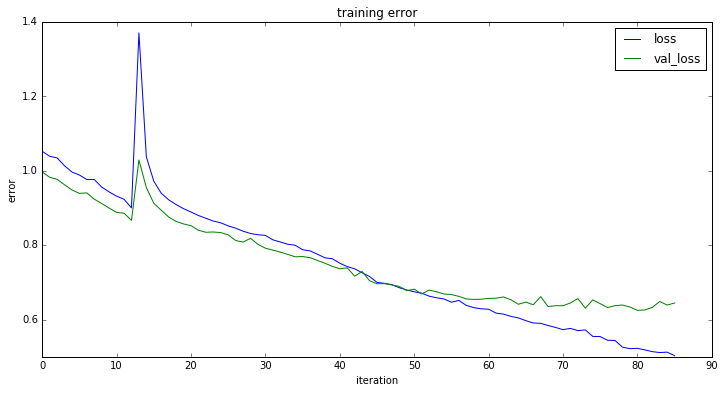

In [31]:
# Train the model each generation and show predictions against the validation dataset

gen_dt_train = DateTimeFormattedGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y)
gen_dt_val   = DateTimeFormattedGenerator(COUNTRY_CODES, VALIDATION_SIZE, MAXLEN_X, MAXLEN_Y)

gen_vec_train      = DateTimeVectorGenerator(gen_dt_train, ctable, INVERT)
gen_vec_validation = DateTimeVectorGenerator(gen_dt_val,   ctable, INVERT)

learning_hist.append(
        model.fit_generator( gen_vec_train, 
                            samples_per_epoch = 33 * TRAINING_SIZE,
                            nb_epoch=EPOCHS, 
                            verbose=1, 
                            callbacks=callbacks_list, 
                            validation_data=gen_vec_validation, 
                            nb_val_samples=VALIDATION_SIZE, 
                            #class_weight={}, 
                            #max_q_size=10, 
                            #nb_worker=1, 
                            #pickle_safe=False
                           )
        )

model.save('../models/datatime_conv_mkI.h5')

for idx in range(5):
    X_test, y_test = next(gen_vec_test)            
    preds = model.predict(X_test, verbose=0)
    i = random.randrange(len(preds))    
    q = ctable.decode(X_test[0][i], MAXLEN_X)    
    correct = ctable.decode(y_test[i], MAXLEN_Y)
    guess = ctable.decode(preds[i], MAXLEN_Y)
    print('Q', q[::-1] if INVERT else q )
    print('T', correct)
    print(colors.ok + '☑' + colors.close if correct == guess else colors.fail + '☒' + colors.close, guess)

visualize_history(learning_hist)            

In [ ]:
MAXLEN_X - MAXLEN_Y

<h1>Results</h1>

epochs_drop = 21.0, HIDDEN_SIZE=MAXLEN_X*1.7

~~~
Build model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
====================================================================================================
locallyconnected1d_34 (LocallyCon(None, 71, 95)        1288295                                      
____________________________________________________________________________________________________
maxpooling1d_34 (MaxPooling1D)   (None, 1, 95)         0                                            
____________________________________________________________________________________________________
locallyconnected1d_35 (LocallyCon(None, 70, 95)        1901900                                      
____________________________________________________________________________________________________
maxpooling1d_35 (MaxPooling1D)   (None, 1, 95)         0                                            
____________________________________________________________________________________________________
locallyconnected1d_36 (LocallyCon(None, 69, 95)        2497455                                      
____________________________________________________________________________________________________
maxpooling1d_36 (MaxPooling1D)   (None, 1, 95)         0                                            
____________________________________________________________________________________________________
dropout_12 (Dropout)             (None, 1, 285)        0           merge_12[0][0]                   
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 285)           0           dropout_12[0][0]                 
____________________________________________________________________________________________________
repeatvector_3 (RepeatVector)    (None, 26, 285)       0           flatten_2[0][0]                  
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 26, 123)       150921      repeatvector_3[0][0]             
____________________________________________________________________________________________________
timedistributed_2 (TimeDistribute(None, 26, 95)        11780       gru_1[0][0]                      
====================================================================================================
Total params: 5850351
~~~

~~~
Epoch 100/106
63315/63315 [==============================] - 27s - loss: 0.0616 - acc: 0.9792 - val_loss: 0.4262 - val_acc: 0.8948
Epoch 101/106
63315/63315 [==============================] - 27s - loss: 0.0596 - acc: 0.9800 - val_loss: 0.4343 - val_acc: 0.8958
Epoch 102/106
63315/63315 [==============================] - 27s - loss: 0.0584 - acc: 0.9805 - val_loss: 0.4297 - val_acc: 0.8930
Epoch 103/106
63315/63315 [==============================] - 27s - loss: 0.0613 - acc: 0.9792 - val_loss: 0.4249 - val_acc: 0.8950
Epoch 104/106
63315/63315 [==============================] - 27s - loss: 0.0565 - acc: 0.9812 - val_loss: 0.4280 - val_acc: 0.8953
Epoch 105/106
63315/63315 [==============================] - 27s - loss: 0.0544 - acc: 0.9820 - val_loss: 0.4303 - val_acc: 0.8948
Epoch 106/106
Learning rate adjusted: 0.0009830400000000003
63315/63315 [==============================] - 27s - loss: 0.0544 - acc: 0.9819 - val_loss: 0.4337 - val_acc: 0.8951
~~~

In [32]:
X_test, y_test = next(gen_vec_validation)            
preds = model.predict(X_test, verbose=0)
for idx in range(10):
    i = random.randrange(len(preds))    
    q = ctable.decode(X_test[0][i], MAXLEN_X)    
    correct = ctable.decode(y_test[i], MAXLEN_Y)
    guess = ctable.decode(preds[i], MAXLEN_Y)
    print('Q', q[::-1] if INVERT else q )
    print('T', correct)
    print(colors.ok + '☑' + colors.close if correct == guess else colors.fail + '☒' + colors.close, guess)

Q Saturday, November 1, 1980 at 7:35:38 PM Alaska Standard Time           
T 1980-11-01T19:35:38-09:19 
☒ 1980-11-12T18:38:38-09:30 
Q Nov 28, 2089, 12:31:15 AM                                               
T 2089-11-28T00:31:15-05:40 
☒ 2089-12-28T00:37:09-07:46 
Q Monday 4 March 2080 at 05:10:35 Greenwich Mean Time                     
T 2080-03-04T05:10:35-00:25 
☒ 2080-03-05T07:15:55-00:00 
Q Nov 28, 2089, 12:31:15 AM                                               
T 2089-11-28T00:31:15-05:40 
☒ 2089-12-28T00:37:09-07:46 
Q September 23, 2064 at 6:58:39 PM CST                                    
T 2064-09-23T18:58:39-06:46 
☒ 2064-09-23T18:57:58-05:46 
Q 12Jan.,2057, 5:16:19 am                                                 
T 2057-01-12T05:16:19+09:56 
☒ 2057-01-22T05:27:19+09:00 
Q Jun 22, 2043, 8:58:58 AM                                                
T 2043-06-22T08:58:58-05:46 
☒ 2043-06-22T08:56:46-05:40 
Q 1/24/61, 9:54 PM                                                   

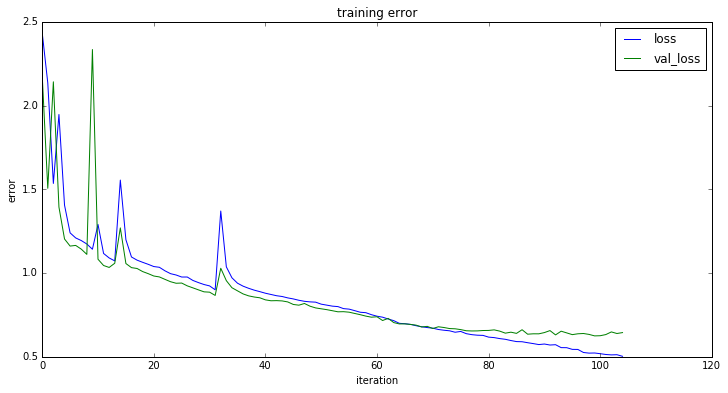

In [33]:
plt.figure(figsize=(12, 6))
discard = int(math.ceil(len(learning_hist)/100))*1
# skip the first few, they destroy plot scale
plt.plot([i for i in learning_hist[-1].history['loss'][discard:]], label='loss')
plt.plot([i for i in learning_hist[-1].history['val_loss'][discard:]], label='val_loss')

plt.ylabel('error')
plt.xlabel('iteration')
plt.legend()
#plt.ylim([0, 0.005])
plt.title('training error')
plt.show()

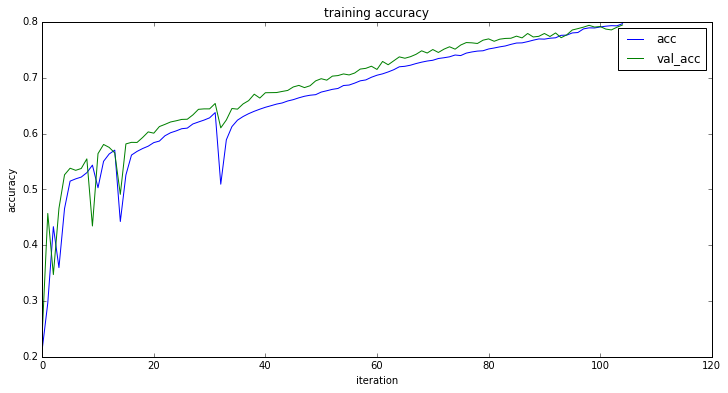

In [34]:
plt.figure(figsize=(12, 6))
discard = int(math.ceil(len(learning_hist)/100))*1
# skip the first few, they destroy plot scale
plt.plot([i for i in learning_hist[-1].history['acc'][discard:]], label='acc')
plt.plot([i for i in learning_hist[-1].history['val_acc'][discard:]], label='val_acc')

plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.legend()
#plt.ylim([0, 0.005])
plt.title('training accuracy')
plt.show()

In [ ]:
#len(learning_hist[0].history['loss'])

In [ ]:
#model.save('../models/datatime_autoencoder_model.h5')

In [ ]:
next(gen_dt)

In [ ]:
#model.load_weights('../models/datatime_conv_mkI.h5')

In [ ]:
!! ls ../models/


In [ ]:
72/3